# Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import pickle

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [2]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo", "SA1", "SA2", "SA3", "SAtotal"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Free up memory
del col, df, predictors_df

# Class Distributions

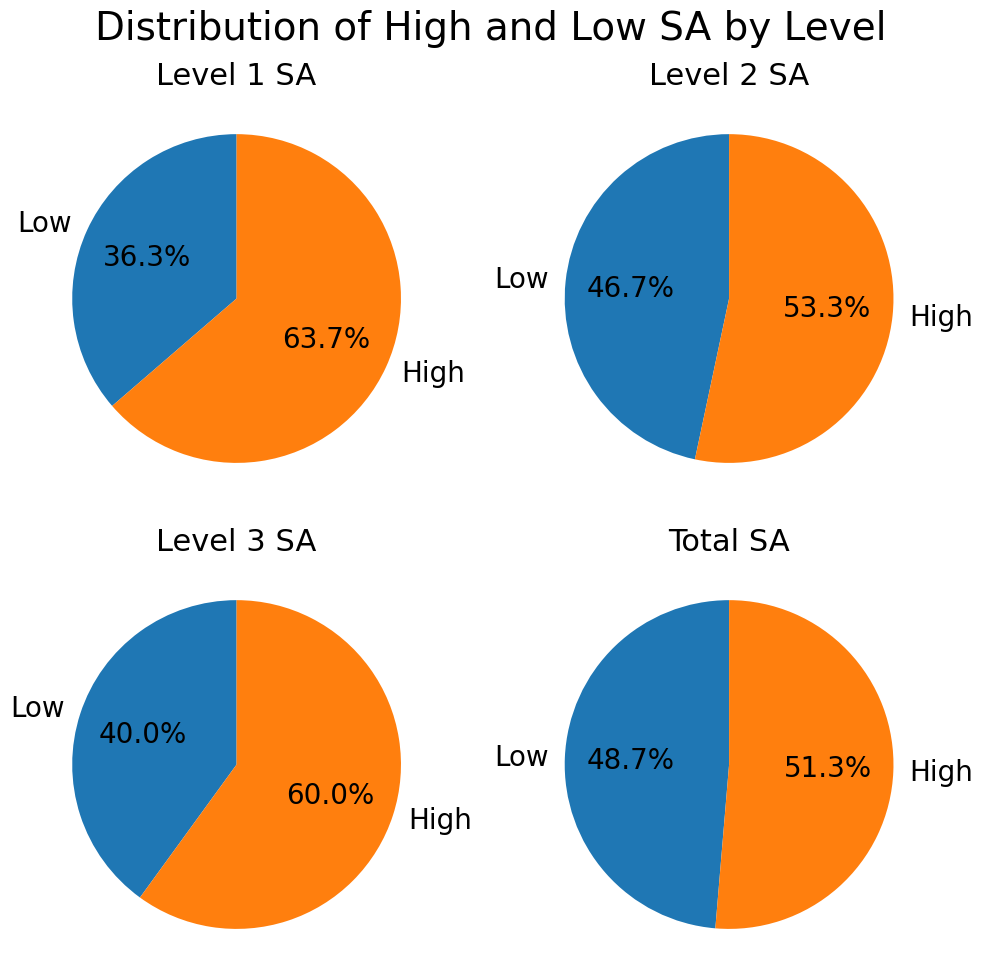

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (10, 10))
labels = ["Low", "High"]
colors = ["C0", "C1"]

ax1[0].set_title("Level 1 SA", fontsize = 22)
ax1[0].pie([np.sum(outcomes_df["Lv_1_Lo"]), np.sum(~outcomes_df["Lv_1_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax1[1].set_title("Level 2 SA", fontsize = 22)
ax1[1].pie([np.sum(outcomes_df["Lv_2_Lo"]), np.sum(~outcomes_df["Lv_2_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[0].set_title("Level 3 SA", fontsize = 22)
ax2[0].pie([np.sum(outcomes_df["Lv_3_Lo"]), np.sum(~outcomes_df["Lv_3_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

ax2[1].set_title("Total SA", fontsize = 22)
ax2[1].pie([np.sum(outcomes_df["Tot_Lo"]), np.sum(~outcomes_df["Tot_Lo"])], labels = labels, colors = colors, autopct = "%1.1f%%", startangle = 90, textprops = {"fontsize": 20})

fig.suptitle("Distribution of High and Low SA by Level", fontsize = 28)
fig.tight_layout()
plt.savefig("./../Images/Paper Figures/Average_Of_3_SA_Distributions.svg")

# F1 and Accuracy Scores

In [5]:
# Load data
with open("./../Pickle Files/Weighted_Average_Scores.pkl", "rb") as f:
    f1_scores, accuracy_scores = pickle.load(f)

del f

In [ ]:
def graph_actual_vs_shuffled(scores, metric):
    # Initialize scores data for plotting
    actual_scores = [scores["Actual"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
    shuffled_scores = [scores["Shuffled"][level] for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

    # Positions for main categories on x-axis
    x_base_positions = np.arange(1, len(actual_scores) + 1) # [1, 2, 3, 4]

    # Width of each individual boxplot
    box_width = 0.4

    # Calculate positions for actual and shuffled boxplots
    # Actual boxplots on left and shuffled on right
    positions_actual = x_base_positions - box_width / 2
    positions_shuffled = x_base_positions + box_width / 2

    # Define colors
    color_actual = "lightblue"
    color_shuffled = "lightcoral"

    # Plot Actual vs Shuffled
    fig = plt.figure(figsize = (3.5, 3))
    plt.boxplot(actual_scores,
                vert = True,
                positions = positions_actual,
                widths = box_width,
                label = "Actual",
                patch_artist = True,
                boxprops = dict(facecolor = color_actual, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    plt.boxplot(shuffled_scores,
                vert = True,
                positions = positions_shuffled,
                widths = box_width,
                label = "Shuffled",
                patch_artist = True,
                boxprops = dict(facecolor = color_shuffled, color = "black"),
                whiskerprops = dict(color = "black"),
                capprops = dict(color = "black"),
                medianprops = dict(color = "black"))
    # Datapoints
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([positions_actual[i], positions_shuffled[i]], [actual_score, shuffled_score], marker = ".")

    # Plot baselines
    score_baselines, always_true_baselines, always_false_baselines = get_baselines(metric)
    xmin_baselines = positions_actual - box_width / 2
    xmax_baselines = positions_shuffled + box_width / 2
    plt.hlines(score_baselines, xmin_baselines, xmax_baselines, color = "black", linestyle = "--", label = f"{metric} Baseline")
    if metric == "F1":
        plt.hlines(always_true_baselines, xmin_baselines, xmax_baselines, color = "r", linestyle = "--", label = "Always True")
    else:
        plt.hlines(always_false_baselines, xmin_baselines, xmax_baselines, color = "b", linestyle = "--", label = "Always False")

    # Labels
    level_labels = ["Level 1 SA", "Level 2 SA", "Level 3 SA", "Total SA"]

    # Customize axes
    plt.title(f"Side-by-Side Boxplots of Actual vs Shuffled {metric} Scores", fontsize = 9)
    plt.ylabel(f"{metric} Score", fontsize = 9)
    plt.ylim(0, 1)
    plt.yticks(fontsize = 8)
    plt.xlabel("SA Level", fontsize = 9)
    plt.xticks(x_base_positions, level_labels, fontsize = 8)

    plt.legend(loc = "lower right", fontsize = 8)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./../Images/Paper Figures/Actual_vs_Shuffled_{metric}_Scores.svg")

def get_baselines(metric):
    # Initialize empty lists to store baseline values
    score_baselines = []
    always_true_baselines = []
    always_false_baselines = []

    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        # Initialize empty lists to store baseline values for `level`
        score_baseline_values = []
        always_true_baseline_values = []
        always_false_baseline_values = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for _, (_, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                score_baseline_values.append((np.mean(out_test[level])) / (np.mean(out_test[level]) + 0.5))
                always_true_baseline_values.append(f1_score(out_test[level], np.array([1 for _ in range(len(out_test[level]))])))
            elif metric == "Accuracy":
                score_baseline_values.append(0.5)
                always_false_baseline_values.append(accuracy_score(outcomes_df[level], np.array([0 for _ in range(len(outcomes_df[level]))])))
        
        # Append the baseline values for the current level
        score_baselines.append(np.mean(score_baseline_values))
        if metric == "F1":
            always_true_baselines.append(np.mean(always_true_baseline_values))
        else:
            always_false_baselines.append(np.mean(always_false_baseline_values))        

    return score_baselines, always_true_baselines, always_false_baselines

## F1 Scores

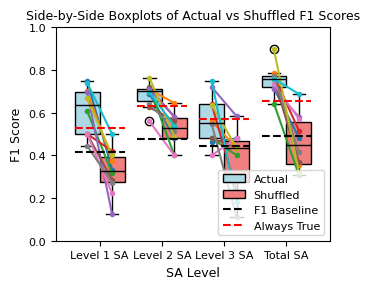

In [105]:
graph_actual_vs_shuffled(f1_scores, "F1")